# Model Selection (Part 3: Training, validation and test data)

ใน part ก่อนหน้า เราได้เห็นตัวอย่างการใช้ polynomial regression มา fit กับข้อมูลที่มีความสัมพันธ์แบบไม่เป็นเชิงเส้น (nonlinear)


*   ถ้าหากเลือก order ของ polynomial ได้อย่างเหมาะสมก็จะช่วยให้ได้โมเดลที่มีความแม่นยำที่สูง
*   ถ้าหากเลือก order ที่ต่ำเกินไป จะเกิดปัญหา underfitting
*   ถ้าหากเลือก order ที่สูงเกินไป ก็จะเกิดปัญหา overfitting

นอกจากนี้ เรายังได้ทดลองใช้เทคนิค regularization มาบรรเทาปัญหา overfitting และได้เห็นถึงความสำคัญในการเลือกค่า $λ$ ที่เหมาะสม


ใน part นี้ เราจะมาลองเรียนรู้วิธีการเลือก order ของ polynomial โดยการใช้การแบ่งข้อมูลของเราออกเป็น 3 ส่วน ประกอบด้วย


1.   Training data - ข้อมูลสำหรับ fit เพื่อหาค่าตัวแปรของโมเดล เช่น $w$ ใน linear regression และ polynomial regression
2.   Validation data - ข้อมูลสำหรับเลือก hyper-parameter เช่น order ของ polynomial
3.   Test data - ข้อมูลสำหรับให้ทดสอบวัดความแม่นยำของโมเดลเท่านั้น กล่าวคือ ข้อมูลชุดนี้จะไม่ถูกนำไป fit เพื่อหาค่าของตัวแปรใดๆ ในโมเดล (เหมือน training data) และข้อมูลนี้ก็ไม่ถูกใช้สำหรับเลือก order ของ polynomial (เหมือน validation data) อีกด้วย







 

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

ฟังก์ชันจาก part ก่อนหน้า

In [ ]:
# ฟังก์ชันสำหรับวัด mean squared error ระหว่างค่าที่ทำนายได้ (y_hat) และค่าผลเฉลย y
def mse(y,y_hat):
  return np.mean((y-y_hat)**2)/y.shape[0]

# ฟังก์ชันสำหรับ fit โมเดล polynomial ที่มี order ที่กำหนด และ ทำนายผลของโมเดลหลังจากถูกสอนด้วย training data แล้ว
def fit_and_predict_polynomial(x_train, # ค่า x ที่ใช้เป็น input ของโมเดล (จาก training data)
                               y_train, # ค่า y ที่ใช้เป็นเฉลยให้โมเดล (จาก training data)
                               poly_order=4, # ค่า order ของ polynomial ที่เราใช้
                               x_test_dict=None, # Python dictionary ที่ใช้เก็บชุดข้อมูลที่เราอยากจะนำมาทดสอบ โดยสามารถเลือกชุดข้อมูลผ่าน key ของ dictionary นี้
                               y_test_dict=None): # Python dictionary ที่ใช้เก็บชุดข้อมูลที่ค่า y ที่เป็นเฉลยของข้อมูลที่นำมาทดสอบ โดยสามารถเลือกชุดข้อมูลผ่าน key ของ dictionary นี้
  
  # สร้างตัวแปรประเภท Python dictionary สำหรับเก็บค่า output ของฟังก์ชันนี้
  mse_dict = {} # ค่า mse
  out_x = {} # ค่า x ที่ใช้เป็น input ของโมเดล
  out_y_hat = {} # ค่า y ที่โมเดลตอบมา
  out_y = {} # ค่า y ที่เป็นเฉลย

  # สร้างโมเดลสำหรับแปลงจาก x เป็น z
  extract_poly_feat = PolynomialFeatures(degree=poly_order, include_bias=True)

  # แปลงจากค่า x ให้กลายเป็น z
  z_train = extract_poly_feat.fit_transform(x_train)

  # สร้างโมเดล y = w_0 + w_1*z + w_2 * z^2 + ...
  model_poly = LinearRegression()

  # สอนโมเดลจาก training data ที่ input ถูก transfrom จาก x มาเป็น z แล้ว
  model_poly.fit(z_train, y_train)

  # ทดสอบโมเดลบน training data
  y_hat_train = model_poly.predict(z_train)

  # ถ้าเกิดว่า user ไม่ได้ให้ test data มา จะใช้ training data เป็น test data
  if x_test_dict is None:
    x_test_dict = {}
    y_test_dict = {}

  # เพิ่ม training data เข้าไปใน test_dict เพื่อที่จะใช้เป็นหนึ่งในข้อมูลสำหรับที่จะให้โมเดลลองทำนาย
  x_test_dict['train'] = x_train
  y_test_dict['train'] = y_train  

  # ทดสอบโมเดลบนข้อมูลแต่ละชุดข้อมูล (แต่ละชุดข้อมูลถูกเลือกจาก key ของ dictionary)
  for curr_mode in x_test_dict.keys():

    # แปลงค่า x ให้เป็น z เหมือนขั้นตอนด้านบนที่เรา fit โมเดล
    z_test = extract_poly_feat.fit_transform(x_test_dict[curr_mode])

    # ทำนายค่า y โดยใช้โมเดล
    y_hat_test = model_poly.predict(z_test)

    # คำนวณค่า mse บน test data
    mse_dict[curr_mode] = mse(y_test_dict[curr_mode], y_hat_test)

    # เตรียมข้อมูลเป็น output ของฟังก์ชันนี้ เผื่อเรียกใช้ภายหลัง เช่น การนำเอาข้อมูลไป plot
    out_x[curr_mode] = x_test_dict[curr_mode] # เก็บค่า x ที่นำมาทดสอบ
    out_y_hat[curr_mode] = y_hat_test # เก็บค่า y ที่โมเดลทำนายออกมา
    out_y[curr_mode] = y_test_dict[curr_mode] # เก็บค่า y ที่เป็นผลเฉลย
  
  return out_x, out_y_hat, out_y, mse_dict, model_poly.coef_[0]


กำหนดให้ข้อมูลที่เราเก็บมานั้นเป็นข้อมูลที่มาจากสมการ $y=sin((x+π/2))^2$ โดยที่ $0<x< \frac{π}{2}$

ถ้าหากว่าเราต้องการประมาณค่าฟังก์ชันนี้ด้วย โมเดลที่เราใช้ใน part ที่แล้ว $y = w_0 + w_1x+ w_2x^2+ ...+ w_p x^p$ เราจะมีวิธีการเลือก order $p$ ของโมเดลนี้อย่างไร

---
สมมติว่าเรามีโอกาสเก็บข้อมูลมาใช้สำหรับ fit โมเดลเพียงแค่ 50 จุด เราสามารถทดลองใช้ขั้นตอนเหล่านี้ในการเลือก order $p$ ของโมเดล


1.   สุ่ม 30% ของข้อมูลที่เก็บมา (30% ของ 50 จุด) มาใช้เป็น validation data $x_{val}$ และ ใช้ที่เหลือ (70% ของ 50 จุด) มาใช้เป็น training data $(x_{train}, y_{train})$

2.   ทดลองสร้าง polynomial ที่มีค่า order $p$ สักค่าหนึ่งมา และใข้ $x_{train}$ ในการ fit โมเดล หรือ การหาค่า $w$ นั่นเอง


3.   หลังจากที่ fit โมเดลเรียบร้อยแล้ว เราจะนำเอาโมเดลมาทำนายค่า $y$ สำหรับทุก ๆ ค่า $x$ ใน $x_{val}$ โดยเราจะเรียกค่าที่โมเดลทำนายออกมาว่า $\hat{y}_{val}$

4.   ใช้ evaluation metric เช่น $MSE(y_{val}, \hat{y}_{val})$ มาคำนวณดูความสามารถของโมเดลในการทำนายค่า

5. ทำซ้ำขั้นตอนที่ 2, 3 และ 4 แต่ใช้ค่า order $p$ ที่เปลี่ยนไปเรื่อยๆ

6. ใช้ $p$ ที่ทำให้โมเดลมีความสามารถในการทำนายค่าบน validation data $(x_{val}, y_{val})$ มากที่สุด เป็นค่า $p$ ที่จะใช้งานจริง

7. นำเอาโมเดล polynomial ที่ใช้ค่า order $p$ จากขั้นตอนที่ 6 มาทดสอบกับ test data


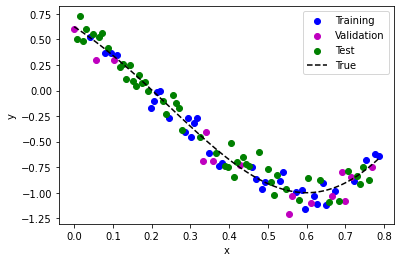

In [ ]:
num_points = 100 # จำนวนจุดที่มีทั้งหมด
num_point_observed = 50 # จำนวนจุดที่เราเก็บมาใช้สอนโมเดล (fit โมเดล)
mode2color_dict = {'train':'b', 'val':'m', 'test':'g'} # กำหนดสีสำหรับแต่ละ mode เช่น สีน้ำเงินสำหรับ training data สีเขียวสำหรับ test data

# สร้างข้อมูลที่ไม่มีสัญญาณรบกวนมาแบบละเอียด เพื่อใช้ในการวาดกราฟ (เส้นประสีดำ)
x_whole_line = np.reshape(np.linspace(0, np.pi/4.0, num_points), (-1,1))
y_true_whole_line = np.sin((x_whole_line + np.pi/2)**2)

# เติมสัญญาณรบกวนเข้าไปในค่า y เพื่อจำลองสถานการณ์ที่มีสัญญาณรบกวนเวลาเก็บข้อมูล
y_noisy = y_true_whole_line + 0.1*np.random.randn(*x_whole_line.shape)

# สมมติเราเก็บข้อมูลมาแค่ num_point_observed จุด และเราจะใช้ 30% ของจุดที่เก็บมาเป็น validation data
fraction_val = 0.3
num_val =  int(num_point_observed*fraction_val)
num_train = num_point_observed - num_val

## สร้าง training data และ validation data จากข้อมูลที่หยิบมาแบบแรนดอม
shuffle_indices = np.random.permutation(range(num_points))
x_whole_line_shuffle = x_whole_line[shuffle_indices]
y_noisy_shuffle = y_noisy[shuffle_indices]

# Training data
x_train = x_whole_line_shuffle[:num_train]
y_train_noisy = y_noisy_shuffle[:num_train]

# Validation data
x_val = x_whole_line_shuffle[num_train:num_train+num_val]
y_val_noisy = y_noisy_shuffle[num_train:num_train+num_val]

# Test data (จุดที่เราไม่ได้เก็บมา ซึ่งมีจำนวนจุด = num_points - num_points_observed)
x_test = x_whole_line_shuffle[num_train+num_val:]
y_test_noisy = y_noisy_shuffle[num_train+num_val:]

# Plot ข้อมูล x, y ที่มีอยู่
fig, ax = plt.subplots()
ax.scatter(x_train, y_train_noisy, c=mode2color_dict['train'], label='Training')
ax.scatter(x_val, y_val_noisy, c=mode2color_dict['val'], label='Validation')
ax.scatter(x_test, y_test_noisy, c=mode2color_dict['test'], label='Test')
ax.plot(x_whole_line, y_true_whole_line, 'k--', label='True' )
ax.set(xlabel='x', ylabel='y')
ax.legend()
plt.show()

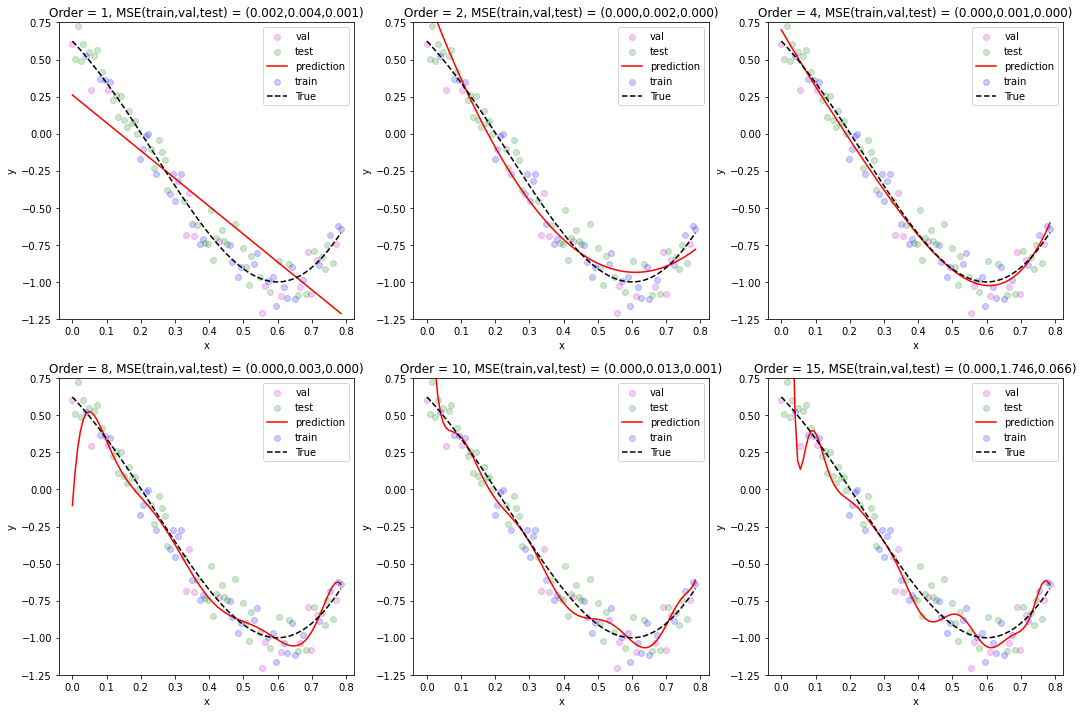

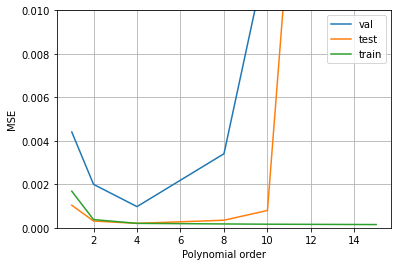

In [ ]:
# สร้าง x_test_dict และ y_test_dict มาเก็บข้อมูลที่เราอยากจะให้โมเดลลองทำนายดู
x_test_dict = {'val': x_val, 'test': x_test, 'all': x_whole_line}
y_test_dict = {'val': y_val_noisy, 'test': y_test_noisy, 'all': y_true_whole_line}

# ลองทดสอบเปลี่ยนค่า polynomial order
poly_order_list = [1,2,4,8,10,15]

# สร้างตัวแปรประเภท dictionary สำหรับเก็บค่า mse ของแต่ละชุดข้อมูล (เช่น train, val และ test)
mse_dict = {}

fig, ax = plt.subplots(2,3, figsize=(18, 12))
fig_row, fig_col = 0,0

# ใช้ for-loop สำหรับทดลองนำเอา polymonial ที่มีค่า order ต่างๆ มา fit กับข้อมูล
for idx, curr_poly_order in enumerate(poly_order_list):

  # fit โมเดล และให้โมเดลทำนายค่า y ออกมา
  curr_outputs = fit_and_predict_polynomial(x_train, 
                                            y_train_noisy, 
                                            poly_order = poly_order_list[idx], 
                                            x_test_dict = x_test_dict, 
                                            y_test_dict = y_test_dict)

  out_x = curr_outputs[0] # ค่า x ที่ถูกใช้ทดสอบโมเดล
  out_y_hat = curr_outputs[1] # ค่า y ที่โมเดลทำนายออกมา
  out_y = curr_outputs[2] # ค่า y ที่เป็นผลเฉลย
  
  # เก็บค่า mse ของแต่ละชุดข้อมูลที่นำมาทดสอบที่มีค่า order ของ polynomial ที่แตกต่างกัน
  for curr_mode in out_x.keys():
    if idx == 0:
      mse_dict[curr_mode] = [curr_outputs[3][curr_mode]]
    else:
      mse_dict[curr_mode].append(curr_outputs[3][curr_mode])

  # แสดงผล
  if idx % 3 == 0 and idx != 0:
    fig_col = 0
    fig_row += 1

  for curr_mode in out_x.keys():
    if curr_mode == 'all':
      # Plot สิ่งที่โมเดลทำนายมาทุกจุด
      ax[fig_row,fig_col].plot(out_x[curr_mode], out_y_hat[curr_mode], 'r', label='prediction')

    else:
      # Plot ข้อมูล "ผลเฉลย" (ในที่นี้เราใช้ข้อมูลที่มีสัญญาณรบกวนเป็นผลเฉลยสำหรับสอน/วัดผลโมเดล เนื่องจากในสถานการณ์จริง บ่อยครั้ง เราไม่สามารถเข้าถึงข้อมูลที่ไม่มีสัญญาณรบกวนได้)
      ax[fig_row,fig_col].scatter(out_x[curr_mode], out_y[curr_mode], c=mode2color_dict[curr_mode], label=curr_mode, alpha=0.2)

  # Plot ข้อมูลที่ไม่มี noise สำหรับเป็น reference ไว้ดู  
  ax[fig_row,fig_col].plot(x_whole_line, y_true_whole_line, 'k--', label='True')
  ax[fig_row,fig_col].set(xlabel='x', ylabel='y')
  ax[fig_row,fig_col].set_title(f"Order = {curr_poly_order}, MSE(train,val,test) = ({mse_dict['train'][idx]:0.3f},{mse_dict['val'][idx]:0.3f},{mse_dict['test'][idx]:0.3f})")
  ax[fig_row,fig_col].set_ylim(-1.25,0.75)
  ax[fig_row,fig_col].legend()

  fig_col += 1

# แสดงผล mse ที่มีค่า order ของ polynomial แตกต่างกัน
plt.figure()
for curr_mode in mse_dict.keys():
  if curr_mode in ['train','val','test']:
    plt.plot(poly_order_list, mse_dict[curr_mode], label=curr_mode)

plt.xlabel('Polynomial order')
plt.ylabel('MSE')
plt.grid()
plt.ylim([0,0.01])
plt.legend()
plt.show()

In [ ]:
print(f"The lowest training MSE was achieved with the polynomial of order {poly_order_list[np.argmin(mse_dict['train'])]}")
print(f"The lowest validation MSE was achieved with the polynomial of order {poly_order_list[np.argmin(mse_dict['val'])]}")
print(f"The lowest test MSE was achieved with the polynomial of order {poly_order_list[np.argmin(mse_dict['test'])]}")

The lowest training MSE was achieved with the polynomial of order 15
The lowest validation MSE was achieved with the polynomial of order 4
The lowest test MSE was achieved with the polynomial of order 4


จากตัวอย่างด้านบน เราสังเกตเห็นว่า 


* order $p$ ที่ให้ค่า MSE บน validation data ต่ำที่สุด ให้ค่าทำนายบน test data  ที่ใกล้เคียงกับค่าที่ถูกต้องมากกว่าค่า $p$ อื่นๆ ที่เราลองทดสอบทั้งหมด

* order $p$ ที่ต่ำกว่าค่าที่เราเลือกมากๆ จะมีปัญหา underfitting อย่างชัดเจน

* order $p$ ที่สูงกว่าค่าที่เราเลือกมากๆ จะมีปัญหา overfitting อย่างชัดเจน

---
นอกจากการแบ่งข้อมูลเป็นส่วน ๆ โดนการเขียนดโค้ดเอง เราสามารถแบ่งข้อมูลผ่านการเรียกใช้ `train_test_split` ของ `sklearn.model_selection` ได้เช่นกัน

นอกจากการแบ่งแบบสุ่มที่เราได้ลองใช้ในตัวอย่างด้านบนแล้ว ยังมีอีกหลายวิธี โดยหนึ่งในวิธีที่ได้รับความนิยมมาก คือ การทำ k-fold cross-validation ซึ่งมีขั้นตอนโดยสังเขปดังนี้


1.   แบ่งชุดข้อมูลออกเป็น k ส่วน (เรียกว่า fold) 

2.   นำเอา 1 fold มาเป็นตัวสำหรับทดสอบโมเดล และนำเอา fold ที่เหลือ (ซึ่งมีทั้งหมด k-1 folds) มาใช้ fit โมเดล และเก็บค่า evaluation metric ไว้

3.  ทำขั้นตอนที่ 2 ซ้ำ แต่จะเลือก fold สำหรับทดสอบที่ไม่เคยนำมาใช้ทดสอบ

ด้วยวิธีนี้ เราจะทำขั้นตอนที่ 2 ทั้งหมด k รอบ (ทุก fold ถูกนำเอามาใช้เป็น fold สำหรับทดสอบ 1 ครั้ง) และเราสามารถนำเอาค่า evaluation metric จากทุก fold มารวมกันเป็นตัวเลขหนึ่งตัว ซึ่งสามารถนำเอาไปใช้ในการเลือก hyperparameter เช่น order ของ polynomial ได้เช่นกัน


ถ้าหากเราเลือก k ที่มีค่าเท่ากับจำนวนจุดข้อมูลที่เรามี เราจะเรียกว่าเราใช้ Leave One Out Cross Validation (LOOCV)

เราสามารถใช้เทคนิค cross validation ผ่านการเรียกใช้ `sklearn.model_selection.cross_val_score` ได้อย่างง่ายดาย

นอกจาก cross validation แล้ว ยังมี bootstrapping ซึ่งเป็นเทคนิคที่คนนิยมใช้เช่นกัน
